In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

/home/tom/mambaforge/envs/mlpg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import h5py

In [3]:
# def _load_h5_file_with_data(self, file_name):
#     path = os.path.join(self.dir_path, file_name)
#     file = h5py.File(path)
#     key = list(file.keys())[0]
#     data = file[key]
#     return dict(file=file, data=data)

# # plt.imshow(np.asarray(_file['2017_02_06_09_15//']))

In [4]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

TRAINING_KEYS_LAST_INDEX = 25000
VALIDATION_KEYS_LAST_INDEX = 40000

AVG_DATA = np.load('/home/tom/local_data/precip_average_train.npy')


class SwedishPrecipitationDataset(Dataset):
    def __init__(self, root: Path, observation_frequency_5_min, lookback_start_5_mins, lookback_intervals_5_mins_multiple, forecast_horizon_5_mins, split: str = 'train'):
        self.root = root
        self.split = split
        self.observation_frequency_5_min = observation_frequency_5_min
        self.lookback_start_5_mins = lookback_start_5_mins
        self.lookback_intervals_5_mins_multiple = lookback_intervals_5_mins_multiple
        self.forecast_horizon_5_mins = forecast_horizon_5_mins
        
        self.data, self.keys = self.load(root)
        
    def load(self, root):
        data = h5py.File(root)
        keys = list(data.keys())
        # keys = list(data.keys())[self.lookback_start_5_mins +1: ]
        
        if self.split == 'train':
            keys = keys[:TRAINING_KEYS_LAST_INDEX]
        
        elif self.split == 'val':
            keys = keys[TRAINING_KEYS_LAST_INDEX: VALIDATION_KEYS_LAST_INDEX]
        
        else:
            keys = keys[VALIDATION_KEYS_LAST_INDEX:]
            
        # keys = keys[list(range(self.lookback_start_5_mins + 1, len(keys), self.observation_frequency_5_min))]
        keys = keys[:5000]
        
        return data, keys
        
    
    def __len__(self):
        return len(self.keys) - self.lookback_start_5_mins - self.forecast_horizon_5_mins
    
    
    def __getitem__(self, index):
        index += self.lookback_start_5_mins
        observation_indicies = [(index - lookback) for lookback in range(0, self.lookback_start_5_mins, self.lookback_intervals_5_mins_multiple)]
        forecast_index = index + self.forecast_horizon_5_mins
        
        X = np.concatenate([(np.asarray(self.data[self.keys[_index]]) - AVG_DATA)[np.newaxis, :, :] for _index in observation_indicies])
        y = np.asarray(self.data[self.keys[forecast_index]] - AVG_DATA)
        
        # print(observation_indicies)
        
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float32)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        # self.down4 = (Down(512, 1024 // factor))
        # self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outconv = (DoubleConv(64, n_channels))
        self.regressor_conv = (OutConv(n_channels, 1))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.down3(x3)
        # x5 = self.down4(x4)
        # x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        out = self.regressor_conv(x)
        return out.reshape(out.shape[0], 881, 458)

In [7]:
training_set = SwedishPrecipitationDataset(Path('/home/tom/local_data/sweden_precip.h5'),12*2, 12*4, 12, 12, split='train')
validation_set = SwedishPrecipitationDataset(Path('/home/tom/local_data/sweden_precip.h5'),12*2, 12*4, 12, 12, split='val')

dataloader = DataLoader(training_set, batch_size=1, shuffle=True, num_workers=10)
val_dataloader = DataLoader(validation_set, batch_size=1, shuffle=True, num_workers=10)

X, y = training_set.__getitem__(0)
mask = (X[0] == 255)

In [8]:
len(list(training_set.data.keys()))

500001

In [9]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(4).to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
from tqdm import tqdm


def train(loss_history):
    
    model.train()
    for batch_index, (batch_X, batch_y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_X)
        _loss = loss(out, batch_y)
        _loss.backward()
        optimizer.step()
        
        if not batch_index % 10:
            loss_history.append(_loss.item())
        
    return loss_history


@torch.no_grad()
def test():
    model.eval()
    validation_loss_history = list()
    
    for _, (batch_X, batch_y) in enumerate(val_dataloader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        out = model(batch_X)
        validation_loss_history.append(loss(out, batch_y).item())
    return validation_loss_history


# best_val_acc = test_acc = 0
loss_hist = list()
val_hist = list()

for epoch in range(0, 30):
    loss_hist = train(loss_hist)
    val_hist.append(test())
    
    # # train_acc, val_acc, tmp_test_acc = test()
    # print(model.edge_weight[:5])
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     test_acc = tmp_test_acc
    # log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    # print(log.format(epoch, train_acc, best_val_acc, test_acc))

100%|██████████| 4940/4940 [13:51<00:00,  5.94it/s]


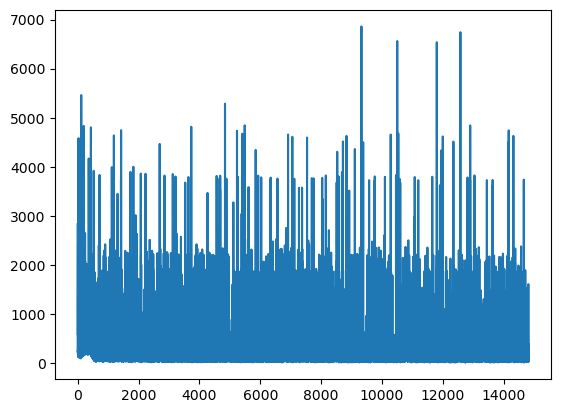

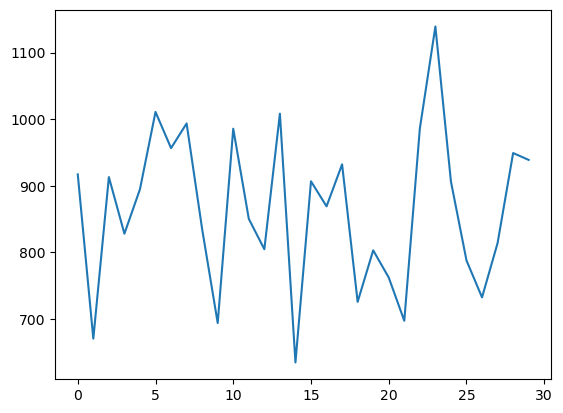

In [11]:
plt.plot(loss_hist)
plt.show()
plt.plot([np.mean(r) for r in val_hist])

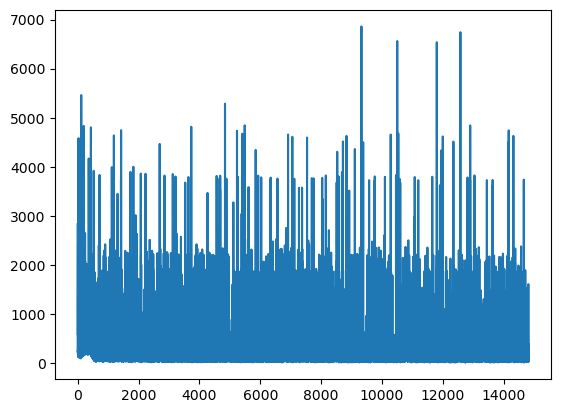

In [12]:
plt.plot(loss_hist)

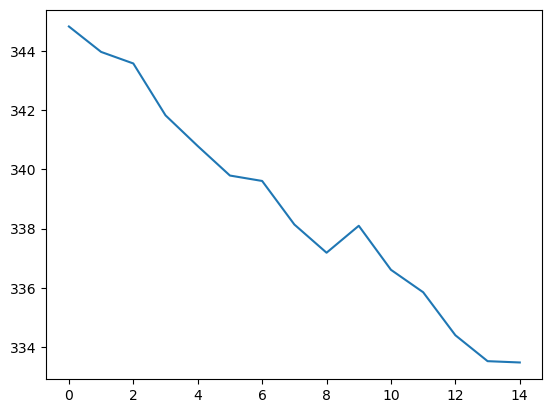

In [28]:
plt.plot([np.mean(r) for r in val_hist])

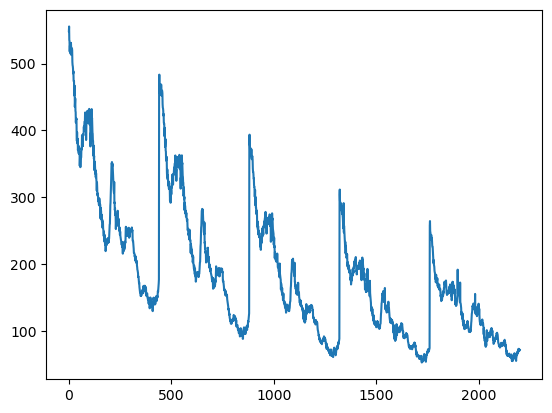

In [12]:
plt.plot([x for x in loss_hist])

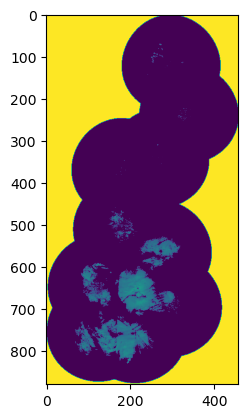

In [11]:
X, y = training_set.__getitem__(0)

plt.imshow(y)

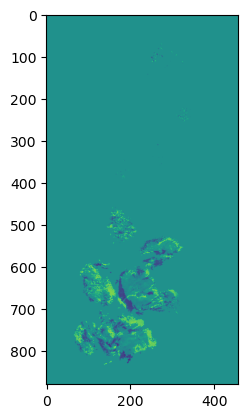

In [12]:
plt.imshow(X[0] - y)

In [13]:
pred = model(X.to(device)[None, : ])

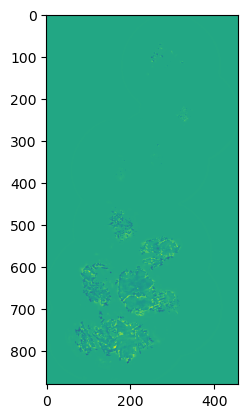

In [14]:
plt.imshow(pred.cpu().detach().numpy().squeeze(axis=0) - y.numpy())

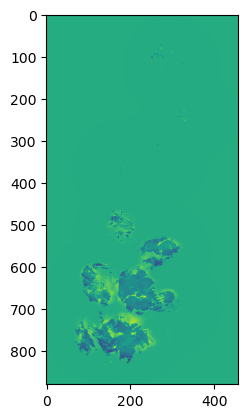

In [17]:
plt.imshow(pred.cpu().detach().numpy().squeeze(axis=0) - y.numpy())

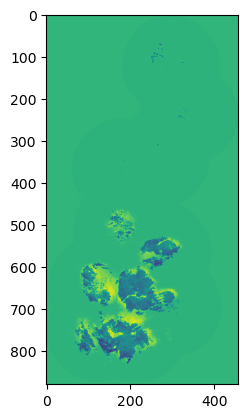

In [40]:
plt.imshow(pred.cpu().detach().numpy().squeeze(axis=0) - y.numpy())

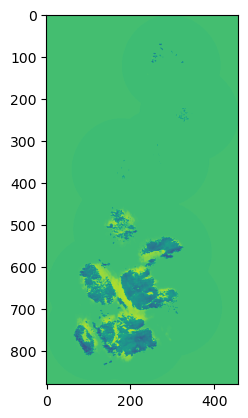

In [41]:
plt.imshow(pred.cpu().detach().numpy().squeeze(axis=0) - X[0].numpy())

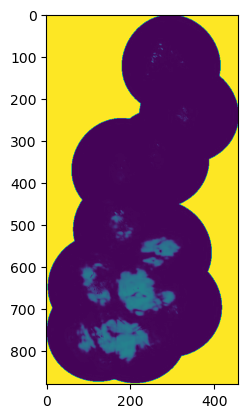

In [15]:
plt.imshow(pred.cpu().detach().numpy().squeeze(axis=0))

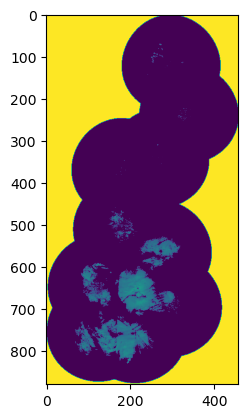

In [34]:
plt.imshow(y)

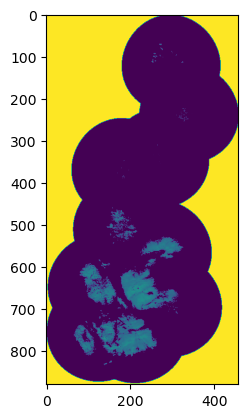

In [35]:
plt.imshow(X[0])

In [36]:
F.mse_loss(X[0], y)

tensor(327.6573)

In [38]:
F.mse_loss(pred, y.to(device))

/tmp/ipykernel_9687/2643500974.py:1: UserWarning: Using a target size (torch.Size([881, 458])) that is different to the input size (torch.Size([1, 881, 458])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(pred, y.to(device))


tensor(251.7031, device='cuda:0', grad_fn=<MseLossBackward0>)

In [16]:
y.shape

torch.Size([881, 458])

In [ ]:
plt.imshow(X)

In [ ]:
plt.

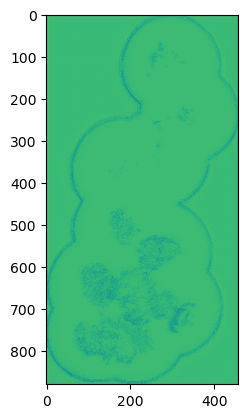

In [27]:
plt.imshow(out[0].detach().numpy())

In [ ]:
plt.plot(loss_hist)

In [11]:
batch_x.shape

torch.Size([5, 4, 881, 458])

In [12]:
model = UNet(4, 1)

In [28]:
out = model(batch_x)

In [30]:
out.shape

torch.Size([5, 1, 881, 458])

In [10]:
X, y = training_set.__getitem__(0)
mask = (X[0] == 255)


In [11]:
mask = (X[0] == 255)

In [49]:
masked = torch.where(mask, 255, out)
breakm

In [52]:
masked[0]

tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]],
       grad_fn=<SelectBackward0>)

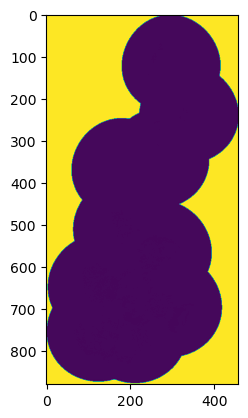

In [51]:
plt.imshow(masked[0].reshape(881, 458).detach().numpy())

In [13]:
out.shape

NameError: name 'out' is not defined

In [17]:
batch_y.shape

torch.Size([5, 881, 458])

In [19]:
out = out.reshape(5, 881, 458)

In [21]:
loss(out, batch_y)

tensor(22974.3984, grad_fn=<MseLossBackward0>)